### Importing the necessary libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

### Set all the constants

In [2]:
BATCH_SIZE = 10
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

### Import data into tensorflow dataset object

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Resume",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 100 files belonging to 2 classes.


In [4]:
class_names=dataset.class_names
class_names

['Non_resume_imgs', 'Resume_imgs']

In [5]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(10, 256, 256, 3)
[0 0 0 1 0 1 1 1 1 1]


### Visualize some of the images from our dataset

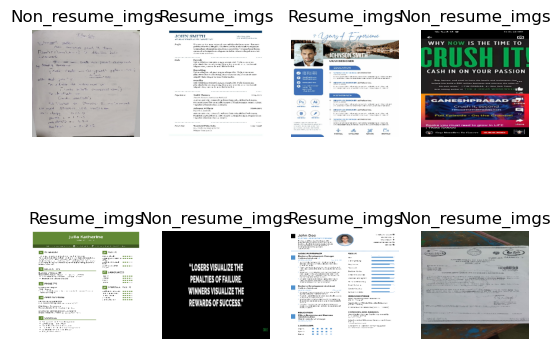

In [6]:
for image_batch,label_batch in dataset.take(1):
    for i in range(8):
        ax=plt.subplot(2,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

### Splitting the Dataset

In [7]:
len(dataset)

10

In [8]:
train_size=0.8
len(dataset)*train_size

8.0

In [9]:
train_ds=dataset.take(8)
len(train_ds)

8

In [10]:
test_ds=dataset.skip(8)
len(test_ds)

2

In [11]:
val_size=0.1
len(dataset)*val_size

1.0

In [12]:
val_ds = test_ds.take(1)
len(val_ds)

1

In [13]:
test_ds = test_ds.skip(1)
len(test_ds)

1

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

8

In [17]:
len(test_ds)

1

In [18]:
len(val_ds)

1

### Cache, Shuffle, and Prefetch the Dataset

In [19]:
train_ds = train_ds.cache().shuffle(10,False).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(10).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(10).prefetch(buffer_size=tf.data.AUTOTUNE)

### Building the Model

### Creating a Layer for Resizing and Normalization

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data augmentation

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

### Applying data augmentation to training dataset

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

### Model Architecture

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (10, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (10, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (10, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (10, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (10, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (10, 246016)             

### Compiling the Model

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)


Epoch 1/50
8/8 [==============================] - 14s 1s/step - loss: 6.1006 - accuracy: 0.4250 - val_loss: 1.3476 - val_accuracy: 0.6000
Epoch 2/50
8/8 [==============================] - 7s 867ms/step - loss: 0.7658 - accuracy: 0.5625 - val_loss: 0.6631 - val_accuracy: 0.5000
Epoch 3/50
8/8 [==============================] - 7s 885ms/step - loss: 0.5905 - accuracy: 0.5375 - val_loss: 0.6386 - val_accuracy: 0.4000
Epoch 4/50
8/8 [==============================] - 7s 849ms/step - loss: 0.5914 - accuracy: 0.6375 - val_loss: 0.6350 - val_accuracy: 0.6000
Epoch 5/50
8/8 [==============================] - 7s 900ms/step - loss: 0.5528 - accuracy: 0.7375 - val_loss: 0.6137 - val_accuracy: 0.6000
Epoch 6/50
8/8 [==============================] - 7s 838ms/step - loss: 0.4908 - accuracy: 0.7500 - val_loss: 0.5655 - val_accuracy: 0.6000
Epoch 7/50
8/8 [==============================] - 7s 807ms/step - loss: 0.4590 - accuracy: 0.7375 - val_loss: 0.5417 - val_accuracy: 0.7000
Epoch 8/50
8/8 [======

In [27]:
scores=model.evaluate(test_ds)

1/1 [==============================] - 3s 3s/step - loss: 0.1344 - accuracy: 0.9000


### Hypertuning the model

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential([
    resize_and_rescale,
    Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    
    Dense(n_classes, activation='softmax'),
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
    #callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/50
8/8 [==============================] - 33s 3s/step - loss: 55.4657 - accuracy: 0.8125 - val_loss: 154.4013 - val_accuracy: 0.5000
Epoch 2/50
8/8 [==============================] - 24s 3s/step - loss: 86.6439 - accuracy: 0.9000 - val_loss: 153.2099 - val_accuracy: 0.5000
Epoch 3/50
8/8 [==============================] - 24s 3s/step - loss: 122.2180 - accuracy: 0.8125 - val_loss: 209.5437 - val_accuracy: 0.5000
Epoch 4/50
8/8 [==============================] - 23s 3s/step - loss: 54.0948 - accuracy: 0.9500 - val_loss: 240.4946 - val_accuracy: 0.6000
Epoch 5/50
8/8 [==============================] - 23s 3s/step - loss: 73.8937 - accuracy: 0.8875 - val_loss: 140.9183 - val_accuracy: 0.7000
Epoch 6/50
8/8 [==============================] - 24s 3s/step - loss: 52.5534 - accuracy: 0.9000 - val_loss: 98.6310 - val_accuracy: 0.8000
Epoch 7/50
8/8 [==============================] - 23s 3s/step - loss: 58.7105 - accuracy: 0.9375 - val_loss: 47.3791 - val_accuracy: 0.9000
Epoch 8/50
8/8

In [30]:
model.evaluate(test_ds)

1/1 [==============================] - 1s 680ms/step - loss: 0.0000e+00 - accuracy: 1.0000


[0.0, 1.0]

### Plotting the Accuracy and Loss Curves

In [31]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 8}

In [32]:
history.history['loss'][:3]

[55.465721130371094, 86.64393615722656, 122.21795654296875]

In [33]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

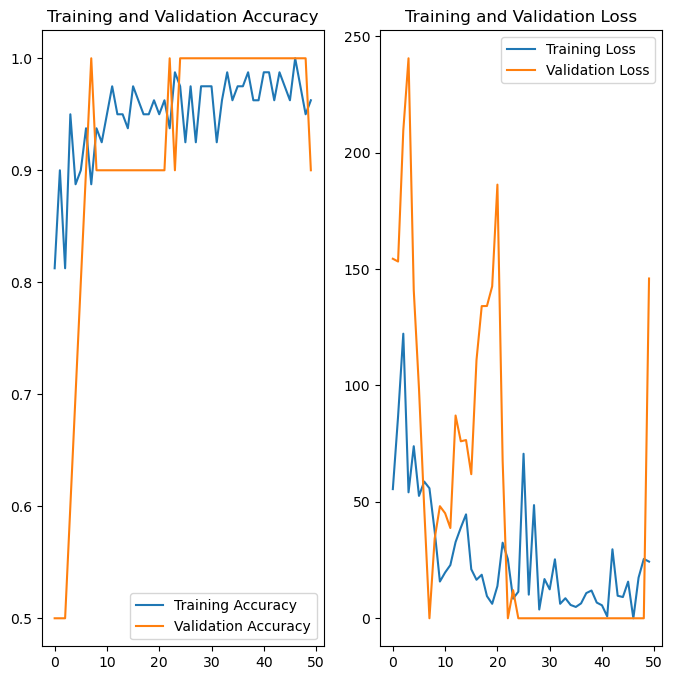

In [34]:
EPOCHS=len(acc)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Run prediction on a sample image

first image to predict
actual label: Non_resume_imgs
1/1 [==============================] - 1s 1s/step
predicted label: Non_resume_imgs


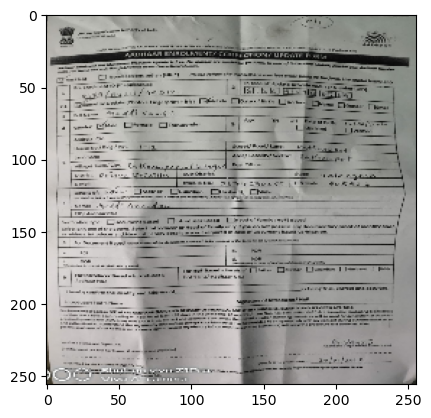

In [35]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[1].numpy().astype('uint8')
    first_label = labels_batch[1].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[1])])

### Confusion Matrix

In [36]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming 'model' is your trained deep learning model
# Assuming 'test_ds' is your test dataset

predictions = []
true_labels = []

for images_batch, labels_batch in test_ds:
    batch_predictions = model.predict(images_batch)
    predictions.extend(np.argmax(batch_predictions, axis=1))
    true_labels.extend(labels_batch.numpy())


1/1 [==============================] - 1s 744ms/step


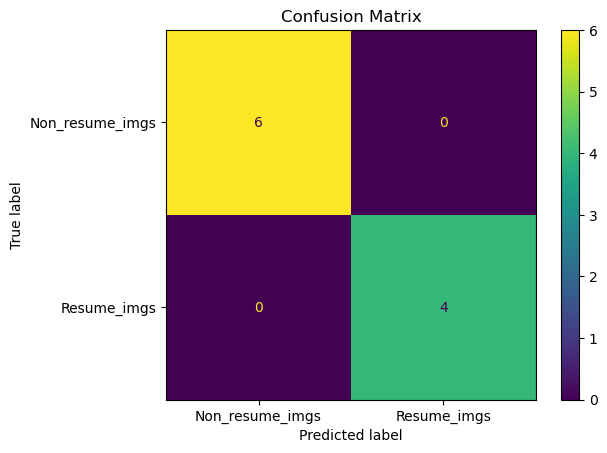

In [37]:
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='viridis', values_format='d')  # You can adjust the colormap and value format as needed
plt.title('Confusion Matrix')
plt.show()


In [38]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score
#print("Accuracy Score for RandomForestClassifier:",accuracy_score(y_test, y_pred))

In [39]:
# Classification report to evaluate different performance metrics
print("Classification Report:\n",classification_report(true_labels, predictions))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

